In [1]:
import numpy as np
import pandas as pd
import random
import statistics
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [80]:
class QuadTree:
    def __init__(self, data, bounding_box=None, max_leaf_data=3):
        if bounding_box is None:
            xs, ys, conditions = zip(*data)
            self.xlo = min(xs)
            self.ylo = min(ys)
            self.xhi = max(xs)*1.01
            self.yhi = max(ys)*1.01
        else:
            self.xlo = bounding_box['xlo']
            self.xhi = bounding_box['xhi']
            self.ylo = bounding_box['ylo']
            self.yhi = bounding_box['yhi']
        if len(data) <= max_leaf_data:
            self._data = data
            self.children = []
        else:
            self._data = None
            self.children = []
            xsplit = (self.xlo + self.xhi) / 2
            ysplit = (self.ylo + self.yhi) / 2
            bbox = [
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': ysplit, 'yhi': self.yhi},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': ysplit, 'yhi': self.yhi}
            ]
            self.children = [
                QuadTree(self.get_data_in_range(data, my_bbox), my_bbox, max_leaf_data)
                for my_bbox in bbox
            ]
    
    def get_descendant_count(self):
        if not self.children:
            return len(self._data)
        else:
            return sum(child.get_descendant_count() for child in self.children)
        
    def get_data_in_range(self, data, bbox):
        result = []
        for x, y, condition in data:
            if bbox['xlo'] <= x < bbox['xhi'] and bbox['ylo'] <= y < bbox['yhi']:
                result.append([x, y, condition])
        return result

    def __repr__(self):
        return f'<QuadTree xlo={self.xlo} ylo={self.ylo} xhi={self.xhi} yhi={self.yhi} #desc={self.get_descendant_count()}>'
    
    

class KNN():
    def __init__(self, data, max_leaf_data=3, k=5):
        self._QTree = QuadTree(data, max_leaf_data=max_leaf_data)
    
    def in_box(self, x, y, xlo, xhi, ylo, yhi):
        return (xlo <= x <= xhi) and (ylo <= y <= yhi)
    
    def dist(self, x1, y1, x2, y2):
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)
    
    def find_R(self, x, y):
        if self.in_box(x, y, self._QTree.xlo, self._QTree.xhi, self._QTree.ylo, self._QTree.yhi):
            Node = self._QTree
            while (Node._data is None):
                for i in range(4):
                    if self.in_box(x, y, Node.children[i].xlo, Node.children[i].xhi, Node.children[i].ylo, Node.children[i].yhi):
                        Node = Node.children[i]
                        break
            return self.dist(Node.xlo, Node.ylo, Node.xhi, Node.yhi)
        else:
            return self.dist(self._QTree.xlo, self._QTree.ylo, self._QTree.xhi, self._QTree.yhi) / 10
        
    def within_d(self, Node, x, y, d):
        if self.in_box(x, y, Node.xlo, Node.xhi, Node.ylo, Node.yhi):
            return True
        elif Node.xlo <= x <= Node.xhi:
            return min(abs(y-Node.ylo), abs(y-Node.yhi)) <= d
        elif self._QTree.ylo <= y <= self._QTree.yhi:
            return min(abs(x-Node.xlo), abs(x-Node.xhi)) <= d
        else:
            return min([
                self.dist(x, y, Node.xlo, Node.ylo), 
                self.dist(x, y, Node.xlo, Node.yhi),
                self.dist(x, y, Node.xhi, Node.ylo),
                self.dist(x, y, Node.xhi, Node.yhi)
            ]) <= d
        
    def points_in_d(self, Node, x, y, d):
        if not Node.children: 
            if self.within_d(Node, x, y, d):
                output = []
                for p in Node._data:
                    if self.dist(x, y, p[0], p[1]) <= d:
                        output.append(p)
                return output
            else:
                return []
        else:
            return self.points_in_d(Node.children[0], x, y, d) + self.points_in_d(Node.children[1], x, y, d) + self.points_in_d(Node.children[2], x, y, d) + self.points_in_d(Node.children[3], x, y, d)
        
    def predict(self, x, y, k):
        try:
            assert(k <= self._QTree.get_descendant_count())
        except: 
            print("Error! k is too large and exceeds the number of dataset.")
        R = self.find_R(x, y)
        while len(self.points_in_d(self._QTree, x, y, R)) < k:
            R *= 2
        pts_within_R = self.points_in_d(self._QTree, x, y, R)
        dist_pts_within_R = [self.dist(x, y, a[0], a[1]) for a in pts_within_R]
        min_i = np.argpartition(dist_pts_within_R, k-1)[:k]
        pts = [pts_within_R[i] for i in min_i]
        return pd.DataFrame(pts)[2].value_counts().keys()[0]
        


In [82]:
def acquire_data(t_size=.8):
    data = pd.read_excel('Rice_Cammeo_Osmancik.xlsx')
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['Class'], axis=1), data['Class'], train_size=t_size)
    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)
    pca = decomposition.PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_train_pc0 = X_train_pca[:, 0]
    X_train_pc1 = X_train_pca[:, 1]
    train = list(zip(X_train_pc0, X_train_pc1, y_train))
    X_test_pca = pca.transform(X_test)
    X_test_pc0 = X_test_pca[:, 0]
    X_test_pc1 = X_test_pca[:, 1]
    test = list(zip(X_test_pc0, X_test_pc1, y_test))
    return train, test

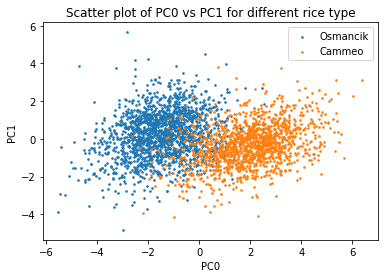

In [107]:
train_data, test_data = acquire_data()
KNN_model = KNN(train)
train_df = pd.DataFrame(train_data)
for rice in ['Osmancik', 'Cammeo']:
    df = train_df[train_df[2] == rice]
    plt.scatter(df[0], df[1], label=rice, s=2.5)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Scatter plot of PC0 vs PC1 for different rice type')
plt.legend()
plt.show()

In [108]:
nevermind1, nevermind2, y_true = zip(*test_data)
y_pred = [KNN_model.predict(test_data[i][0], test_data[i][1], 1) for i in range(len(test_data))]
confusion_matrix(y_true, y_pred)

array([[292,  30],
       [ 32, 408]])

In [109]:
nevermind1, nevermind2, y_true = zip(*test_data)
y_pred = [KNN_model.predict(test_data[i][0], test_data[i][1], 5) for i in range(len(test_data))]
confusion_matrix(y_true, y_pred)

array([[297,  25],
       [ 24, 416]])